# GBDT模型处理学生考勤数据

# 1. 学生考勤数据整理

1.1 将老师课堂上的考勤数据整理为txt格式(‘studentsData.txt’)，txt内容截图如下：

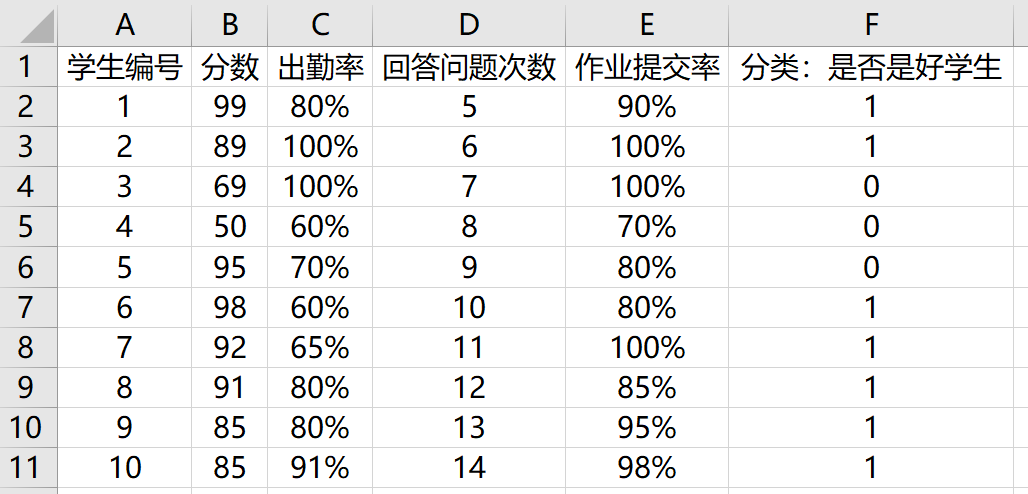

# 2. 手写代码实现GBDT

In [1]:
import pandas as pd
import random
import os
import abc
import shutil
import logging
import math
from PIL import Image
import pydotplus as pdp
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [2]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# 随机划分训练集和测试集
def dataSeperate(X, testRatio):
    dataNumber = len(X)  # 数据集数据条数
    testNumber = int(dataNumber * testRatio)  # 测试集数据条数
    X_test = [] 
    X_train = []
    randIndex = random.sample(range(dataNumber), testNumber)
    for i in randIndex:
        X_test.append(X[i])
    for n in range(dataNumber):
        if n not in randIndex:
            X_train.append(X[n])
    return X_train, X_test

In [4]:
class AbstractBaseGradientBoosting(metaclass=abc.ABCMeta):
    def __init__(self):
        pass

    def fit(self, data):
        pass

    def predict(self, data):
        pass

In [5]:
class BaseGradientBoosting(AbstractBaseGradientBoosting):

    def __init__(self, loss, learning_rate, n_trees, max_depth,
                 min_samples_split=2, is_log=False, is_plot=False):
        super().__init__()
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.features = None
        self.trees = {}
        self.f_0 = {}
        self.is_log = is_log
        self.is_plot = is_plot

    def fit(self, data):
        """
        :param data: pandas.DataFrame, the features data of train training   
        """
        # 掐头去尾， 删除id和label，得到特征名称
        self.features = list(data.columns)[1: -1]
        # 初始化 f_0(x)
        # 对于平方损失来说，初始化 f_0(x) 就是 y 的均值
        self.f_0 = self.loss.initialize_f_0(data)
        # 对 m = 1, 2, ..., M
        logger.handlers[0].setLevel(logging.INFO if self.is_log else logging.CRITICAL)
        for iter in range(1, self.n_trees+1):
            if len(logger.handlers) > 1:
                logger.removeHandler(logger.handlers[-1])
            #fh = logging.FileHandler('results/NO.{}_tree.log'.format(iter), mode='w', encoding='utf-8')
            fh = logging.FileHandler(resultsPath+'/NO.{}_tree.log'.format(iter), mode='w', encoding='utf-8')
            fh.setLevel(logging.DEBUG)
            logger.addHandler(fh)
            # 计算负梯度--对于平方误差来说就是残差
            logger.info(('-----------------------------构建第%d颗树-----------------------------' % iter))
            self.loss.calculate_residual(data, iter)
            target_name = 'res_' + str(iter)
            self.trees[iter] = Tree(data, self.max_depth, self.min_samples_split,
                                    self.features, self.loss, target_name, logger)
            self.loss.update_f_m(data, self.trees, iter, self.learning_rate, logger)
            if self.is_plot:
                plot_tree(self.trees[iter], max_depth=self.max_depth, iter=iter)
        # print(self.trees)
        if self.is_plot:
            plot_all_trees(self.n_trees)

In [6]:
class LossFunction(metaclass=abc.ABCMeta):

    @abc.abstractmethod
    def initialize_f_0(self, data):
        """初始化 F_0 """

    @abc.abstractmethod
    def calculate_residual(self, data, iter):
        """计算负梯度"""

    @abc.abstractmethod
    def update_f_m(self, data, trees, iter, learning_rate, logger):
        """计算 F_m """

    @abc.abstractmethod
    def update_leaf_values(self, targets, y):
        """更新叶子节点的预测值"""

    @abc.abstractmethod
    def get_train_loss(self, y, f, iter, logger):
        """计算训练损失"""

In [7]:
# loss Function
class BinomialDeviance(LossFunction):

    def initialize_f_0(self, data):
        pos = data['label'].sum()
        neg = data.shape[0] - pos
        # 此处log是以e为底，也就是ln
        f_0 = math.log(pos / neg)
        data['f_0'] = f_0
        return f_0

    def calculate_residual(self, data, iter):
        # calculate negative gradient
        res_name = 'res_' + str(iter)
        f_prev_name = 'f_' + str(iter - 1)
        data[res_name] = data['label'] - 1 / (1 + data[f_prev_name].apply(lambda x: math.exp(-x)))

    def update_f_m(self, data, trees, iter, learning_rate, logger):
        f_prev_name = 'f_' + str(iter - 1)
        f_m_name = 'f_' + str(iter)
        data[f_m_name] = data[f_prev_name]
        for leaf_node in trees[iter].leaf_nodes:
            data.loc[leaf_node.data_index, f_m_name] += learning_rate * leaf_node.predict_value
        # 打印每棵树的 train loss
        self.get_train_loss(data['label'], data[f_m_name], iter, logger)

    def update_leaf_values(self, targets, y):
        numerator = targets.sum()
        if numerator == 0:
            return 0.0
        denominator = ((y - targets) * (1 - y + targets)).sum()
        if abs(denominator) < 1e-150:
            return 0.0
        else:
            return numerator / denominator

    def get_train_loss(self, y, f, iter, logger):
        loss = -2.0 * ((y * f) - f.apply(lambda x: math.exp(1+x))).mean()
        logger.info(('第%d棵树: log-likelihood:%.4f' % (iter, loss)))

In [8]:
# GBDT二分类模型
class GradientBoostingBinaryClassifier(BaseGradientBoosting):
    def __init__(self, learning_rate=0.1, n_trees=5, max_depth=3,
                 min_samples_split=2, is_log=False, is_plot=False):
        super().__init__(BinomialDeviance(), learning_rate, n_trees, max_depth,
                         min_samples_split, is_log, is_plot)

    def predict(self, data):
        data['f_0'] = self.f_0
        for iter in range(1, self.n_trees + 1):
            f_prev_name = 'f_' + str(iter - 1)
            f_m_name = 'f_' + str(iter)
            data[f_m_name] = data[f_prev_name] + \
                             self.learning_rate * \
                             data.apply(lambda x: self.trees[iter].root_node.get_predict_value(x), axis=1)
        data['predict_proba'] = data[f_m_name].apply(lambda x: 1 / (1 + math.exp(-x)))
        data['predict_label'] = data['predict_proba'].apply(lambda x: 1 if x >= 0.5 else 0)

In [9]:
class Node:
    def __init__(self, data_index, logger=None, split_feature=None, split_value=None, is_leaf=False, loss=None,
                 deep=None):
        self.loss = loss
        self.split_feature = split_feature
        self.split_value = split_value
        self.data_index = data_index
        self.is_leaf = is_leaf
        self.predict_value = None
        self.left_child = None
        self.right_child = None
        self.logger = logger
        self.deep = deep

    def update_predict_value(self, targets, y):
        self.predict_value = self.loss.update_leaf_values(targets, y)
        self.logger.info(('叶子节点预测值：', self.predict_value))

    def get_predict_value(self, instance):
        if self.is_leaf:
            self.logger.info(('predict:', self.predict_value))
            return self.predict_value
        if instance[self.split_feature] < self.split_value:
            return self.left_child.get_predict_value(instance)
        else:
            return self.right_child.get_predict_value(instance)

In [10]:
class Tree:
    def __init__(self, data, max_depth, min_samples_split, features, loss, target_name, logger):
        self.loss = loss
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.features = features
        self.logger = logger
        self.target_name = target_name
        self.remain_index = [True] * len(data)
        self.leaf_nodes = []
        self.root_node = self.build_tree(data, self.remain_index, depth=0)

    def build_tree(self, data, remain_index, depth=0):
        """
        此处有三个树继续生长的条件：
            1: 深度没有到达最大, 树的深度假如是3， 意思是需要生长成3层, 那么这里的depth只能是0, 1 
                所以判断条件是 depth < self.max_depth - 1
            2: 点样本数 >= min_samples_split
            3: 此节点上的样本的 target_name 值不一样（如果值 一样说明已经划分得很好了，不需要再分）
        """
        now_data = data[remain_index]

        if depth < self.max_depth - 1 \
                and len(now_data) >= self.min_samples_split \
                and len(now_data[self.target_name].unique()) > 1:
            se = None
            split_feature = None
            split_value = None
            left_index_of_now_data = None
            right_index_of_now_data = None
            self.logger.info(('--树的深度：%d' % depth))
            for feature in self.features:
                self.logger.info(('----划分特征：', feature))
                feature_values = now_data[feature].unique()
                for fea_val in feature_values:
                    # 尝试划分
                    left_index = list(now_data[feature] < fea_val)
                    right_index = list(now_data[feature] >= fea_val)
                    left_se = calculate_se(now_data[left_index][self.target_name])
                    right_se = calculate_se(now_data[right_index][self.target_name])
                    sum_se = left_se + right_se
                    self.logger.info(('------划分值:%.3f,左节点损失:%.3f,右节点损失:%.3f,总损失:%.3f' %
                                      (fea_val, left_se, right_se, sum_se)))
                    if se is None or sum_se < se:
                        split_feature = feature
                        split_value = fea_val
                        se = sum_se
                        left_index_of_now_data = left_index
                        right_index_of_now_data = right_index
            self.logger.info(('--最佳划分特征：', split_feature))
            self.logger.info(('--最佳划分值：', split_value))

            node = Node(remain_index, self.logger, split_feature, split_value, deep=depth)
            """ 
            trick for DataFrame, index revert
            下面这部分代码是为了记录划分后样本在原始数据中的的索引
            DataFrame的数据索引可以使用True和False
            所以下面得到的是一个bool类型元素组成的数组
            利用这个数组进行索引获得划分后的数据
            """
            left_index_of_all_data = []
            for i in remain_index:
                if i:
                    if left_index_of_now_data[0]:
                        left_index_of_all_data.append(True)
                        del left_index_of_now_data[0]
                    else:
                        left_index_of_all_data.append(False)
                        del left_index_of_now_data[0]
                else:
                    left_index_of_all_data.append(False)

            right_index_of_all_data = []
            for i in remain_index:
                if i:
                    if right_index_of_now_data[0]:
                        right_index_of_all_data.append(True)
                        del right_index_of_now_data[0]
                    else:
                        right_index_of_all_data.append(False)
                        del right_index_of_now_data[0]
                else:
                    right_index_of_all_data.append(False)

            node.left_child = self.build_tree(data, left_index_of_all_data, depth + 1)
            node.right_child = self.build_tree(data, right_index_of_all_data, depth + 1)
            return node
        else:
            node = Node(remain_index, self.logger, is_leaf=True, loss=self.loss, deep=depth)
            if len(self.target_name.split('_')) == 3:
                label_name = 'label_' + self.target_name.split('_')[1]
            else:
                label_name = 'label'
            node.update_predict_value(now_data[self.target_name], now_data[label_name])
            self.leaf_nodes.append(node)
            return node

In [11]:
def calculate_se(label):
    mean = label.mean()
    se = 0
    for y in label:
        se += (y - mean) * (y - mean)
    return se

In [12]:
def plot_multi(trees: dict, max_depth: int, iter: int):
    trees_traversal = {}
    trees_nodes = {}
    for class_index in trees.keys():
        tree = trees[class_index]
        res = []
        root = tree.root_node
        traversal(root,res)
        trees_traversal[class_index] = res
        # 获取所有节点
        nodes = {}
        index = 0
        for i in res:
            p, c = i[0], i[1]
            if p not in nodes.values():
                nodes[index] = p
                index = index + 1
            if c not in nodes.values():
                nodes[index] = c
                index = index + 1
        trees_nodes[class_index] = nodes
        # 通过dot语法将决策树展示出来
    trees_edges = {}
    trees_node = {}
    for class_index in trees.keys():
        trees_node[class_index] = ''
        trees_edges[class_index] = ''
    for depth in range(max_depth):
        for class_index in trees.keys():
            for nodepair in trees_traversal[class_index]:
                if nodepair[0].deep == depth:
                    p, c = nodepair[0], nodepair[1]
                    l = len([i for i in range(len(c.data_index)) if c.data_index[i] is True])
                    pname = str(list(trees_nodes[class_index].keys())[list(trees_nodes[class_index].values()).index(p)])
                    cname = str(list(trees_nodes[class_index].keys())[list(trees_nodes[class_index].values()).index(c)])
                    if l > 0:
                        trees_edges[class_index] = trees_edges[class_index] + pname + '->' + cname + '[label=\"' + str(p.split_feature) + (
                            '<' if p.left_child == c else '>=') + str(p.split_value) + '\"]' + ';\n'

                        trees_node[class_index] = trees_node[class_index] + pname + '[width=1,height=0.5,color=lemonchiffon,style=filled,shape=ellipse,label=\"id:' + str(
                        [i for i in range(len(p.data_index)) if p.data_index[i] is True]) + '\"];\n' + \
                           (
                               cname + '[width=1,height=0.5,color=lemonchiffon,style=filled,shape=ellipse,label=\"id:' + str(
                                   [i for i in range(len(c.data_index)) if
                                    c.data_index[i] is True]) + '\"];\n' if l > 0 else '')
                    if c.is_leaf and l > 0:
                        trees_edges[class_index] = trees_edges[class_index] + cname + '->' + cname + 'p[style=dotted];\n'
                        trees_node[class_index] = trees_node[class_index] + cname + 'p[width=1,height=0.5,color=lightskyblue,style=filled,shape=box,label=\"' + str(
                            "{:.4f}".format(c.predict_value)) + '\"];\n'
                else:
                    continue
            dot = '''digraph g {\n''' + trees_edges[class_index] + trees_node[class_index] + '''}'''
            graph = pdp.graph_from_dot_data(dot)
            # 保存图片+pyplot展示
            # graph.write_png('results/NO.{}_{}_tree.png'.format(iter, class_index))
            graph.write_png(resultsPath+'/NO.{}_{}_tree.png'.format(iter, class_index))
        plt.ion()
        plt.figure(1, figsize=(30, 20))
        plt.axis('off')
        plt.title('NO.{} iter '.format(iter))
        class_num = len(trees.keys())
        if class_num / 3 - int(class_num / 3) <0.000001:
            rows = int(class_num/3)
        else:
            rows = int(class_num/3)+1
        for class_index in trees.keys():
            index = list(trees.keys()).index(class_index)
            plt.subplot(rows, 3, index+1)
            # img = Image.open('results/NO.{}_{}_tree.png'.format(iter, class_index))
            img = Image.open(resultsPath+'/NO.{}_{}_tree.png'.format(iter, class_index))
            img = img.resize((1024, 700), Image.ANTIALIAS)
            plt.axis('off')
            plt.title('NO.{}_class {}'.format(iter, class_index))
            plt.rcParams['figure.figsize'] = (30.0, 20.0)
            plt.imshow(img)
        # plt.savefig('results/NO.{}_tree.png'.format(iter))
        plt.savefig(resultsPath+'/NO.{}_tree.png'.format(iter))
        plt.pause(0.01)

In [13]:
def plot_tree(tree: Tree, max_depth: int, iter: int):
    """
           展示单棵决策树
    :param tree: 生成的决策树
    :param max_depth: 决策树的最大深度
    :param iter: 第几棵决策树
    :return:
    """
    root = tree.root_node
    res = []
    # 通过遍历获取决策树的父子节点关系，可选有traversal 层次遍历 和traversal_preorder 先序遍历
    traversal(root, res)

    # 获取所有节点
    nodes = {}
    index = 0
    for i in res:
        p, c = i[0], i[1]
        if p not in nodes.values():
            nodes[index] = p
            index = index + 1
        if c not in nodes.values():
            nodes[index] = c
            index = index + 1

    # 通过dot语法将决策树展示出来
    edges = ''
    node = ''
    # 将节点层次展示
    for depth in range(max_depth):
        for nodepair in res:
            if nodepair[0].deep == depth:
                # p,c分别为节点对中的父节点和子节点
                p, c = nodepair[0], nodepair[1]
                l = len([i for i in range(len(c.data_index)) if c.data_index[i] is True])
                pname = str(list(nodes.keys())[list(nodes.values()).index(p)])
                cname = str(list(nodes.keys())[list(nodes.values()).index(c)])
                if l > 0:
                    edges = edges + pname + '->' + cname + '[label=\"' + str(p.split_feature) + (
                        '<' if p.left_child == c else '>=') + str(p.split_value) + '\"]' + ';\n'

                node = node + pname + '[width=1,height=0.5,color=lemonchiffon,style=filled,shape=ellipse,label=\"id:' + str(
                    [i for i in range(len(p.data_index)) if p.data_index[i] is True]) + '\"];\n' + \
                       (cname + '[width=1,height=0.5,color=lemonchiffon,style=filled,shape=ellipse,label=\"id:' + str(
                    [i for i in range(len(c.data_index)) if c.data_index[i] is True]) + '\"];\n' if l > 0 else '')
                if c.is_leaf and l > 0:
                    edges = edges + cname + '->' + cname + 'p[style=dotted];\n'
                    node = node + cname + 'p[width=1,height=0.5,color=lightskyblue,style=filled,shape=box,label=\"' + str(
                        "{:.4f}".format(c.predict_value)) + '\"];\n'
            else:
                continue
        dot = '''digraph g {\n''' + edges + node + '''}'''
        graph = pdp.graph_from_dot_data(dot)
        # 保存图片+pyplot展示
        # graph.write_png('results/NO.{}_tree.png'.format(iter))
        graph.write_png(resultsPath+'/NO.{}_tree.png'.format(iter))
        # img = Image.open('results/NO.{}_tree.png'.format(iter))
        img = Image.open(resultsPath+'/NO.{}_tree.png'.format(iter))
        img = img.resize((1024, 700), Image.ANTIALIAS)
        plt.ion()
        plt.figure(1, figsize=(30, 20))
        plt.axis('off')
        plt.title('NO.{} tree'.format(iter))
        plt.rcParams['figure.figsize'] = (30.0, 20.0)
        plt.imshow(img)
        plt.pause(0.01)


In [14]:
def plot_all_trees(numberOfTrees: int):
    '''
           将所有生成的决策树集中到一张图中展示
    :param numberOfTrees: 决策树的数量
    :return:
    '''
    # 每行展示3棵决策树 根据决策树数量决定行数
    if numberOfTrees / 3 - int(numberOfTrees / 3) > 0.000001:
        rows = int(numberOfTrees / 3)+1
    else:
        rows = int(numberOfTrees / 3)
    # 利用subplot 将所有决策树在一个figure中展示
    plt.figure(1, figsize=(30,20))
    plt.axis('off')
    try:
        for index in range(1, numberOfTrees + 1):
            # path = os.path.join('results', 'NO.{}_tree.png'.format(index))
            path = resultsPath+'/NO.{}_tree.png'.format(index)
            plt.subplot(rows, 3, index)
            img = Image.open(path)
            img = img.resize((1000, 800), Image.ANTIALIAS)
            plt.axis('off')
            plt.title('NO.{} tree'.format(index))
            plt.imshow(img)
        # plt.savefig('results/all_trees.png', dpi=300)
        plt.savefig(resultsPath+'/all_trees.png', dpi=300)
        plt.show()
        # 由于pyplot图片像素不是很高，使用方法生成高质量的图片
        image_compose(numberOfTrees)
    except Exception as e:
        raise e


In [15]:
def image_compose(numberOfTrees: int):
    '''
           将numberOfTrees棵决策树的图片拼接到一张图片上
    :param numberOfTrees: 决策树的数量
    :return:
    '''

    png_to_compose = []
    # 获取每张图片的size
    for index in range(1,numberOfTrees+1):
        png_to_compose.append('NO.{}_tree.png'.format(index))
    try:
        # path = os.path.join('results', png_to_compose[0])
        path = resultsPath+'/'+png_to_compose[0]
        shape = Image.open(path).size
    except Exception as e:
        raise e
    IMAGE_WIDTH = shape[0]
    IMAGE_HEIGET = shape[1]
    IMAGE_COLUMN = 3

    if len(png_to_compose)/IMAGE_COLUMN - int(len(png_to_compose)/IMAGE_COLUMN) > 0.0000001:
        IMAGE_ROW = int(len(png_to_compose)/IMAGE_COLUMN)+1
    else:
        IMAGE_ROW = int(len(png_to_compose) / IMAGE_COLUMN)
    # 新建一张用于拼接的图片
    to_image = Image.new('RGB', (IMAGE_COLUMN*IMAGE_WIDTH, IMAGE_ROW*IMAGE_HEIGET), '#FFFFFF')
    # 拼接图片
    for y in  range(IMAGE_ROW):
        for x in range(IMAGE_COLUMN):
            if y*IMAGE_COLUMN+x+1 > len(png_to_compose):
                break
            # path = os.path.join('results', 'NO.'+str(y*IMAGE_COLUMN+x+1)+'_tree.png')
            path = resultsPath+'/'+'NO.'+str(y*IMAGE_COLUMN+x+1)+'_tree.png'
            from_image = Image.open(path)
            to_image.paste(from_image, (x*IMAGE_WIDTH, y*IMAGE_HEIGET))

    # to_image.save('results/all_trees_high_quality.png')
    to_image.save(resultsPath+'/all_trees_high_quality.png')



In [16]:
def traversal_preorder(root: Node, res: list):
    '''

          先序遍历决策树获取节点间的父子关系
    :param root: 决策树的根节点
    :param res:  存储节点对(父节点,子节点)的list
    :return: res
    '''
    if root is None:
        return
    if root.left_child is not None:
        res.append([root, root.left_child])
        traversal_preorder(root.left_child, res)
    if root.right_child is not None:
        res.append([root, root.right_child])
        traversal_preorder(root.right_child, res)



In [17]:
def traversal(root: Node, res: list):
    '''

              层次遍历决策树获取节点间的父子关系
        :param root: 决策树的根节点
        :param res:  存储节点对(父节点,子节点)的list
        :return: res
        '''
    outList = []
    queue = [root]
    while queue != [] and root:
        outList.append(queue[0].data_index)
        if queue[0].left_child != None:
            queue.append(queue[0].left_child)
            res.append([queue[0], queue[0].left_child])
        if queue[0].right_child != None:
            queue.append(queue[0].right_child)
            res.append([queue[0], queue[0].right_child])
        queue.pop(0)


In [18]:
# 单次训练&测试
def testFun(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    print('Precision is %f'%precision)
    print('Recall is %f'%recall)
    return precision, recall

In [19]:
# 加载数据
dataPath = '../../data/studentsData_for_GBDT.txt'
fr = open(dataPath)
X = [inst.strip().split('\t') for inst in fr.readlines()]
X_name = ['Score','AttandanceRate','AnswerNums','HomeworkRate','label']
X_train, X_test = dataSeperate(X, 0.3)
# 创建训练集
X_train = pd.DataFrame(data=X_train, dtype = float,columns=X_name)
# 列表二维切片
X_test_slice=[X_test[i][0:len(X_name)-1] for i in range(0,len(X_test))]
# 格式转换
y_test_true = [X_test[i][-1] for i in range(0,len(X_test))]
# 格式转换
y_test_true = [int(i) for i in y_test_true] 
# 创建测试集
X_test = pd.DataFrame(data=X_test_slice, dtype = float, columns=X_name[0:len(X_name)-1])

In [20]:
X_train.head(10)

,Score,AttandanceRate,AnswerNums,HomeworkRate,label
0,89.0,1.00,6.0,1.00,1.0
1,95.0,0.70,9.0,0.80,0.0
2,98.0,0.60,10.0,0.80,1.0
3,92.0,0.65,11.0,1.00,1.0
4,91.0,0.80,12.0,0.85,1.0
5,85.0,0.80,13.0,0.95,1.0
6,85.0,0.91,14.0,0.98,1.0


In [21]:
X_test.head(10)

,Score,AttandanceRate,AnswerNums,HomeworkRate
0,69.0,1.0,7.0,1.0
1,50.0,0.6,8.0,0.7
2,99.0,0.8,5.0,0.9


In [22]:
# 创建存储模型结果的目录
resultsPath = '../../results/GBDT'
if not os.path.exists(resultsPath):
    os.makedirs(resultsPath)
if len(os.listdir(resultsPath)) > 0:
    shutil.rmtree(resultsPath)
    os.makedirs(resultsPath)

In [23]:
# 建立模型
model = GradientBoostingBinaryClassifier(learning_rate=0.1, n_trees=5, max_depth=10,
                                                 is_log=False, is_plot=False)

In [24]:
# 训练模型
model.fit(X_train)

In [25]:
# 记录日志
logger.removeHandler(logger.handlers[-1])
logger.addHandler(logging.FileHandler(resultsPath+'/result.log'.format(iter), mode='w', encoding='utf-8'))
logger.info(X_train)

In [26]:
# 模型预测
model.predict(X_test)

In [27]:
# 添加预测日志
logger.info((X_test['predict_proba']))
logger.info((X_test['predict_label']))

In [28]:
# 计算模型精确率和召回率
acc, recall = testFun(y_test_true,X_test['predict_label'].values.tolist())

Precision is 0.333333
Recall is 0.333333


# 3. 调库实现GBDT

In [29]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib as mpl
import matplotlib.pyplot as plt

In [30]:
# 加载数据
dataPath = '../../data/studentsData_for_GBDT.txt'
fr = open(dataPath)
X = [inst.strip().split('\t') for inst in fr.readlines()]
X_name = ['Score','AttandanceRate','AnswerNums','HomeworkRate','label']
X_train, X_test = dataSeperate(X, 0.3)
# 训练集标签切片
y_train_true = [X_train[i][-1] for i in range(0,len(X_train))]
# 训练集特征切片
X_train=[X_train[i][0:len(X_name)-1] for i in range(0,len(X_train))]
# 训练集标签列表格式转换
y_train_true = [int(i) for i in y_train_true] 
# 训练集特征格式转换
X_train = pd.DataFrame(data=X_train, dtype = float, columns=X_name[0:len(X_name)-1])
X_train = X_train.values.tolist()

# 测试集标签切片
y_test_true = [X_test[i][-1] for i in range(0,len(X_test))]
# 测试集特征切片
X_test=[X_test[i][0:len(X_name)-1] for i in range(0,len(X_test))]
# 测试集标签列表格式转换
y_test_true = [int(i) for i in y_test_true] 
# 测试集特征格式转换
X_test = pd.DataFrame(data=X_test, dtype = float, columns=X_name[0:len(X_name)-1])
X_test = X_test.values.tolist()

In [31]:
gbdt = GradientBoostingClassifier(max_depth=4, criterion = 'mse')

In [32]:
gbdt.fit(X_train, y_train_true)

GradientBoostingClassifier(criterion='mse', max_depth=4)

In [33]:
score_feature = gbdt.feature_importances_
print(score_feature)

[1.00000000e+00 9.94376895e-18 1.46063585e-17 4.15022854e-17]


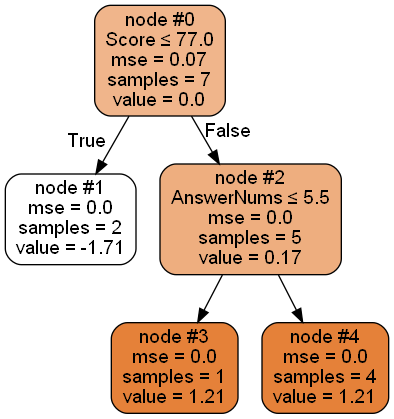

In [34]:
from IPython.display import Image  
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

# 拟合训练6棵树
sub_tree = gbdt.estimators_[5, 0]
dot_data = export_graphviz(sub_tree, out_file=None, feature_names = X_name[0:4], filled=True, rounded=True, special_characters=True, precision=2, node_ids=True,class_names=['good','not good'])
graph = graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [35]:
y_pred = gbdt.predict(X_test)

In [36]:
acc, recall = testFun(y_test_true, y_pred)

Precision is 0.666667
Recall is 0.666667
